In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import imutils

## Image Preprocessing

### Import Image

In [2]:
img_num = 0
eye_image = cv2.imread(f'C:/Users/jimyj/Desktop/TAIST/Thesis/Source_Code/CASIA-IrisV2/device1/00{str(img_num).zfill(2)}/00{str(img_num).zfill(2)}_000.bmp')
gray_eye_image = cv2.cvtColor(eye_image, cv2.COLOR_BGR2GRAY)

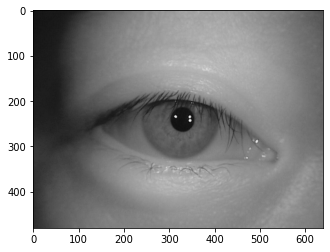

In [3]:
# gray_eye_image = gray_eye_image[50:320, 50:450]
plt.imshow(gray_eye_image, cmap='gray')

In [4]:
lash_threshold = 50
ref = gray_eye_image < lash_threshold
coords = np.where(ref == 1)
temp = gray_eye_image.astype(float)
temp[coords] = float('nan')

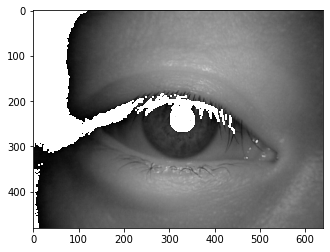

In [5]:
plt.imshow(temp, cmap='gray')

### Iris Localization

#### Houghman Circle Detection
- Find Pupil

##### Slow Houghman

In [6]:
def get_edges(image):
        edges = cv2.Canny(image, 20, 100)
        kernel = np.ones((3, 3), np.uint8)
        edges = cv2.dilate(edges, kernel, iterations=2)
        # ksize = 2 * random.randrange(5, 11) + 1
        edges = cv2.GaussianBlur(edges, (15, 15), 0)
        return edges

In [7]:
def find_pupil(img):
    param1 = 200  # 200
    param2 = 120  # 150
    pupil_circles = []
    while(param2 > 35 and len(pupil_circles) < 100):
        for mdn, thrs in [(m, t)
                          for m in [3, 5, 7]
                          for t in [20, 25, 30, 35, 40, 45, 50, 55, 60]]:
            # Median Blur
            median = cv2.medianBlur(img, 2*mdn+1)

            # Threshold
            _, thres = cv2.threshold(
                median, thrs, 255,
                cv2.THRESH_BINARY_INV)

            # Canny Edges
            edges = get_edges(thres)

            # HoughCircles
            circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 1,
                                       np.array([]), param1, param2)
            if circles is not None:
                # convert the (x, y) coordinates and radius of the circles
                # to integers
                circles = np.round(circles).astype("int")
                for c in circles:
                    pupil_circles.append(c)

        param2 = param2 - 10

    cimg = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    if circles is None:
        return
    mean_0 = int(np.mean([c[0][0] for c in circles]))
    mean_1 = int(np.mean([c[0][1] for c in circles]))
    mean_2 = int(np.mean([c[0][2] for c in circles]))

    return mean_0, mean_1, mean_2


##### Fast Houghman

In [8]:
def find_pupil_new(img):
    param1 = 200  # 200
    param2 = 120  # 150
    circles = None
    while circles is None and param2 > 20:
        # HoughCircles
        circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 1,
                                    param1=param1, param2=param2,
                                    minRadius=20, maxRadius=60)

        param2 -= 1
    
    if circles is None:
        return None, None, None

    return circles.astype(int)[0][0]

In [9]:
def find_iris_new(img):
    param1 = 200  # 200
    param2 = 120  # 150
    circles = None
    while circles is None and param2 > 20:
        # HoughCircles
        circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 1,
                                    param1=param1, param2=param2,
                                    minRadius=60, maxRadius=500)

        param2 -= 1
    
    if circles is None:
        return None, None, None

    return circles.astype(int)[0][0]

#### Image Processing
- Apply filter for active contour to segment Iris

In [10]:
DoG = cv2.GaussianBlur(gray_eye_image, (3, 3), 0) - cv2.GaussianBlur(gray_eye_image, (25, 25), 0)
median1 = cv2.medianBlur(DoG, 3)
eroted = cv2.erode(median1, np.ones((3, 3), np.uint8), iterations=1)
median2 = cv2.medianBlur(eroted, 5)
dilated = cv2.dilate(median2, np.ones((3, 3), np.uint8), iterations=1)
eroted = cv2.erode(dilated, np.ones((5, 5), np.uint8), iterations=1)
result = cv2.bitwise_or(gray_eye_image, eroted)

Text(0.5, 1.0, 'Result')

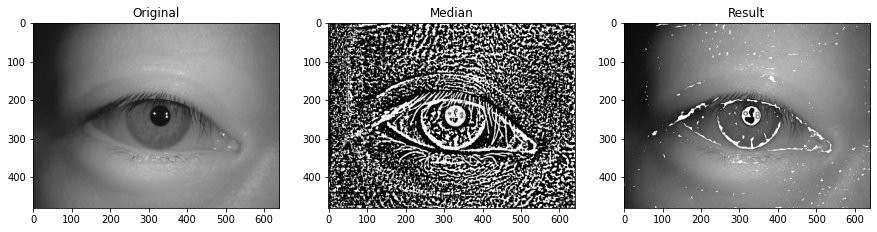

In [11]:
plt.figure(figsize=(15,10))
plt.subplot(1,3,1),plt.imshow(gray_eye_image,cmap = 'gray')
plt.title('Original')
plt.subplot(1,3,2),plt.imshow(DoG,cmap = 'gray')
plt.title('Median')
plt.subplot(1,3,3),plt.imshow(result,cmap = 'gray')
plt.title('Result')

In [12]:
from skimage.filters import gaussian
from skimage.segmentation import active_contour
import math

#### Canny Edge Detection Check

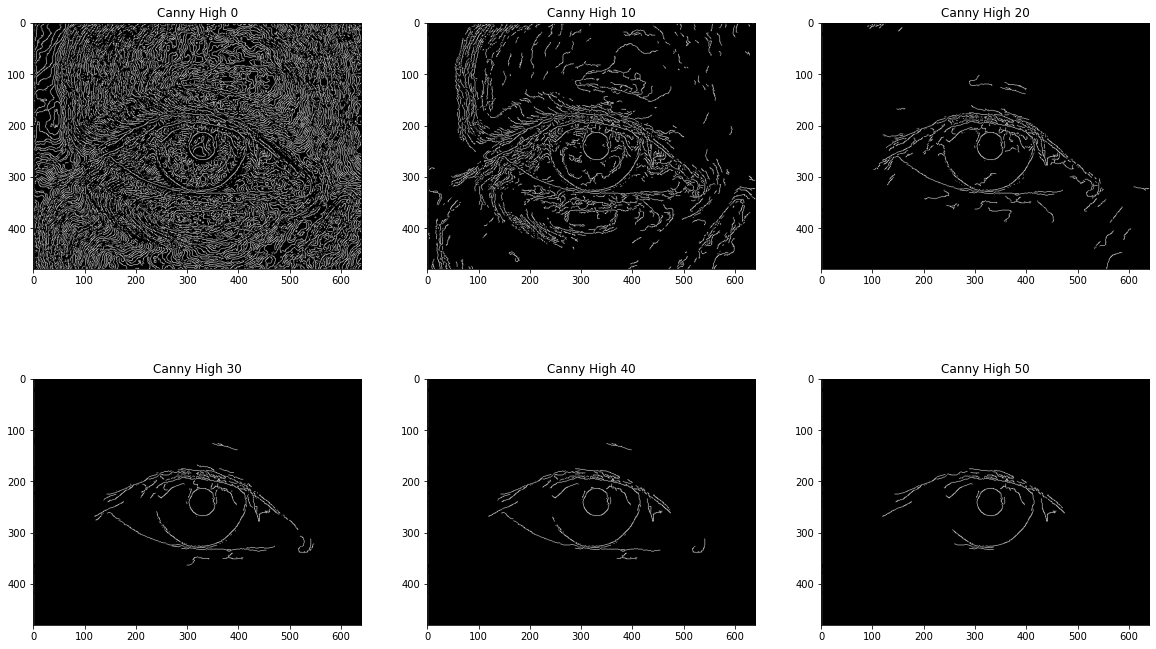

In [13]:
img_num = 6
plot_cols = 3
plot_size = 6
plot_rows = math.ceil(img_num / plot_cols)

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(20, plot_size*plot_rows))

for i in range(img_num):
    filter_size = 15
    canny_low = 0
    canny_high = i*10
    
    test = cv2.medianBlur(gray_eye_image, filter_size)
    test = cv2.Canny(test, canny_low, canny_high)
    
    x = i//plot_cols
    y = i-(i//plot_cols)*plot_cols
    
    ax[x, y].imshow(test, cmap=plt.cm.gray)
    ax[x, y].set_title(f'Canny High {canny_high}')

#### Find Pupil

In [14]:
filter_size = 15
canny_low = 0
canny_high = 50

In [15]:
x_pupil, y_pupil, rad_pupil = find_pupil_new(cv2.Canny(cv2.medianBlur(gray_eye_image, filter_size), canny_low, canny_high))

In [16]:
if rad_pupil is None:
    print('No pupil found')
    s = np.linspace(0, 2*np.pi, 400)
    c = 350 + 200*np.cos(s)
    r = 250 + 200*np.sin(s)

    init = np.array([r, c]).T
    
    temp = cv2.medianBlur(gray_eye_image, filter_size)
    temp = cv2.Canny(temp, 0, 20)

    snake_pupil = active_contour(temp, init, alpha=4, beta=1000, gamma=0.05)

    x_pupil, y_pupil, rad_pupil = 350, 250, None

#### Snake parameter:
```python
beta = [300, 500, 1000]
```

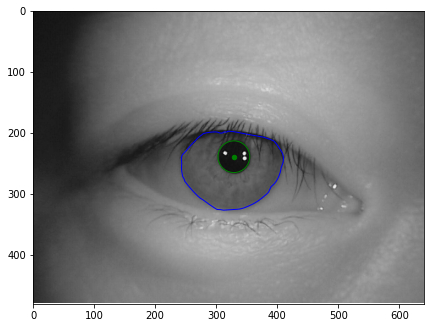

In [17]:
s = np.linspace(0, 2*np.pi, 400)
c = x_pupil + 150*np.cos(s)
r = y_pupil + 150*np.sin(s)

init = np.array([r, c]).T

snake = active_contour(result, init, alpha=1.45, beta=590, w_line=0.01, gamma=0.01)
# contours = imutils.grab_contours(snake)
# contours = sorted(contours, key = cv2.contourArea, reverse = True)[:1]
# iris_boundary = cv2.approxPolyDP(contours[0], 0.01 * cv2.arcLength(contours[0], True), True)

# x_iris, y_iris, rad_iris = find_iris_new(result)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(gray_eye_image, cmap=plt.cm.gray)
# ax.plot(init[:, 1], init[:, 0], '--r', lw=1)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=1)
ax.axis([0, gray_eye_image.shape[1], gray_eye_image.shape[0], 0])

if rad_pupil is None:
    print(f"No circles found in image {i}")
    ax.plot(snake_pupil[:, 1], snake_pupil[:, 0], 'g', lw=1)

try:
    circle = plt.Circle((x_pupil, y_pupil), rad_pupil, color='g', fill=False, linewidth=1)
    ax.add_patch(circle)
    ax.scatter(x_pupil, y_pupil, s=20, c='g', marker='o')
except:
    print('No pupil found')

# circle = plt.Circle((x_iris, y_iris), rad_iris, color='r', fill=False, linewidth=1)
# ax.add_patch(circle)
# ax.scatter(x_iris, y_iris, s=20, c='r', marker='o')

plt.show()

#### Mask

In [18]:
mask1 = np.zeros_like(gray_eye_image)
mask1 = cv2.circle(mask1, (x_pupil, y_pupil), rad_pupil, (255,255,255), -1)
mask2 = np.zeros_like(gray_eye_image)
mask2[snake[:,0].astype(int), snake[:,1].astype(int)] = 255

In [19]:
contours, _ = cv2.findContours(mask2, 2,2)
for i in range(len(contours)):
    cv2.drawContours(mask2, contours, i, (255,255,255), 3, cv2.LINE_8)

In [20]:
contours, hierarchies = cv2.findContours(mask2, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
for cnt in contours:
    cv2.drawContours(mask2, [cnt], -1, 255, -1)

In [21]:
mask = cv2.subtract(mask2, mask1)

Text(0.5, 1.0, 'Mask All')

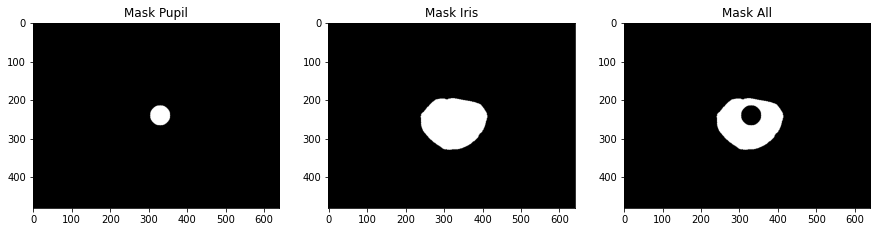

In [22]:
plt.figure(figsize=(15,10))
plt.subplot(1,3,1),plt.imshow(mask1,cmap = 'gray')
plt.title('Mask Pupil')
plt.subplot(1,3,2),plt.imshow(mask2,cmap = 'gray')
plt.title('Mask Iris')
plt.subplot(1,3,3),plt.imshow(mask,cmap = 'gray')
plt.title('Mask All')

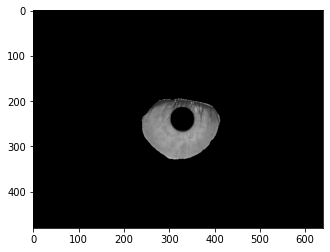

In [23]:
masked_gray = cv2.bitwise_and(gray_eye_image, gray_eye_image, mask=mask)
plt.imshow(masked_gray, cmap='gray')

### Iris Normalization

#### Changes polar coordinates to cartesian coordinate system.

- param circle: (x, y, radius)
- param theta: angle
- return: new coordinates (x, y)
- rtype: tuple (int, int)

In [24]:
def trans_axis(circle, theta):

    x0, y0, r = circle
    x = int(x0 + r * math.cos(theta))
    y = int(y0 + r * math.sin(theta))
    return x, y

#### Normalize the iris.

- param img: the input img
- param pupil_circle: (x, y, radius)
- param iris_circle: (x, y, radius)
- param M, N: the normalization image size
- param offset: the initial angle
- return: the normalization image
- rtype: ndarray

In [25]:
def normalization(img, pupil_circle, iris_circle, M=64, N=400, offset=0):

    normalized = np.zeros((M, N))
    theta = np.linspace(0, 2 * np.pi, N)

    for i in range(N):
        curr_theta = theta[i] + offset
        if curr_theta > 2 * np.pi:
            curr_theta -= 2 * np.pi
        begin = trans_axis(pupil_circle, curr_theta)
        end = iris_circle

        xspace = np.linspace(begin[0], end[i][0], M)
        yspace = np.linspace(begin[1], end[i][1], M)
        normalized[:, i] = [img[int(y), int(x)]
                            if 0 <= int(x) < img.shape[1] and 0 <= int(y) < img.shape[0]
                            else 0
                            for x, y in zip(xspace, yspace)]
    return normalized

In [26]:
def normalization_active(img, pupil_circle, iris_circle, M=64, N=400, offset=0):

    normalized = np.zeros((M, N))
    theta = np.linspace(0, 2 * np.pi, N)

    for i in range(N):
        curr_theta = theta[i] + offset
        if curr_theta > 2 * np.pi:
            curr_theta -= 2 * np.pi
        # begin = trans_axis(pupil_circle, curr_theta)
        begin = pupil_circle
        end = iris_circle

        xspace = np.linspace(begin[i][0], end[i][0], M)
        yspace = np.linspace(begin[i][1], end[i][1], M)
        normalized[:, i] = [255 - img[int(y), int(x)]
                            if 0 <= int(x) < img.shape[1] and 0 <= int(y) < img.shape[0]
                            else 0
                            for x, y in zip(xspace, yspace)]
    return normalized

In [27]:
def lash_removal(img, thresh=40):
    ref = img < thresh
    coords = np.where(ref == 1)
    rmov_img = img.astype(float)
    rmov_img[coords] = float('nan')
    return rmov_img

In [28]:
def lash_removal_daugman(img, thresh=40):
    ref = img < thresh
    coords = np.where(ref == 1)
    rmov_img = img.astype(float)
    rmov_img[coords] = float('nan')
    temp_img = rmov_img.copy()
    temp_img[coords] = 255/2
    avg = np.sum(temp_img) / (rmov_img.shape[0] * rmov_img.shape[1])
    rmov_img[coords] = avg
    
    noise_img = np.zeros(img.shape)
    noise_img[coords] = 1
    return rmov_img, noise_img.astype(bool)

In [29]:
def lash_removal_test(img, thresh=20):
    diff_img = np.subtract(img[:,0:199], img[:,200:399])
    coords = np.array(np.where(diff_img > thresh))
    coords[1] = coords[1] + 200
    coords = coords.tolist()
    rmov_img = img.astype(float)
    rmov_img[coords] = 255
    return rmov_img

#### Plot Normalized Iris

In [30]:
pupil_circle = (x_pupil, y_pupil, rad_pupil)
# pupil_circle = np.flip(np.array(snake_pupil).astype(int), 1)
iris_circle = np.flip(np.array(snake).astype(int), 1)

iris_norm = normalization(gray_eye_image, pupil_circle, iris_circle)

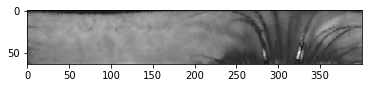

In [31]:
plt.imshow(iris_norm, cmap='gray')

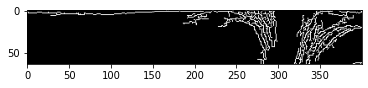

In [32]:
test = cv2.Canny(np.uint8(iris_norm), 0, 200)
plt.imshow(test, cmap='gray')

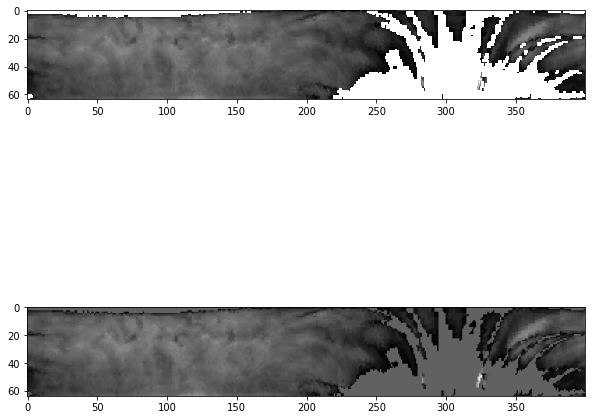

In [33]:
# rmov_img_test = lash_removal_test(iris_norm, thresh=40)
rmov_img= lash_removal(iris_norm, thresh=50)
rmov_img_d, noise_img_d = lash_removal_daugman(iris_norm, thresh=50)
fig, ax = plt.subplots(2, 1, figsize=(10,10))
ax[0].imshow(rmov_img, cmap='gray')
ax[1].imshow(rmov_img_d, cmap='gray')

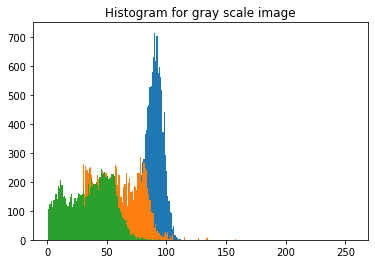

In [34]:
plt.hist(iris_norm[:,0:199].ravel(),256,[1,256])
plt.hist(iris_norm[:,200:399].ravel(),256,[1,256])
plt.hist(np.subtract(iris_norm[:,0:199], iris_norm[:,200:399]).ravel(),256,[1,256])
plt.title('Histogram for gray scale image')
plt.show()

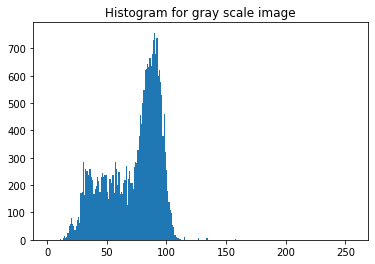

In [35]:
plt.hist(iris_norm.ravel(),256,[1,256])
plt.title('Histogram for gray scale image')
plt.show()

In [36]:
from scipy import ndimage as ndi

In [37]:
def defined_gabor_kernel(frequency, sigma_x=None, sigma_y=None,
                         n_stds=3, offset=0, theta=0):

    x0 = np.ceil(max(np.abs(n_stds * sigma_x * np.cos(theta)),
                     np.abs(n_stds * sigma_y * np.sin(theta)), 1))
    y0 = np.ceil(max(np.abs(n_stds * sigma_y * np.cos(theta)),
                     np.abs(n_stds * sigma_x * np.sin(theta)), 1))
    y, x = np.mgrid[-y0:y0 + 1, -x0:x0 + 1]

    g = np.zeros(y.shape, dtype=complex)
    g[:] = np.exp(-0.5 * (x ** 2 / sigma_x ** 2 + y ** 2 / sigma_y ** 2))
    g /= 2 * np.pi * sigma_x * sigma_y
    g *= np.cos(2 * np.pi * frequency * ((x ** 2 + y ** 2) ** 0.5))

    return g

In [38]:
def defined_gabor(img, frequency, sigma_x, sigma_y):

    g = defined_gabor_kernel(frequency, sigma_x, sigma_y)
    filtered_real = ndi.convolve(img, np.real(g), mode='wrap', cval=0)

    return filtered_real

In [39]:
iris_code = defined_gabor(rmov_img, frequency= 32 *np. pi /180, sigma_x=3, sigma_y=1.5)

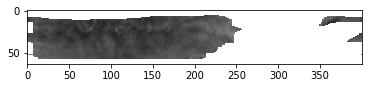

In [40]:
plt.imshow(iris_code, cmap='gray')

In [41]:
def gaborconvolve_f(img, minw_length, mult, sigma_f):
    """
    Convolve each row of an imgage with 1D log-Gabor filters.
    """
    rows, ndata = img.shape
    logGabor_f = np.zeros(ndata)
    filterb = np.zeros([rows, ndata], dtype=complex)

    radius = np.arange(ndata/2 + 1) / (ndata/2) / 2
    radius[0] = 1

    # filter wavelength
    wavelength = minw_length

    # radial filter component 
    fo = 1 / wavelength
    logGabor_f[0: int(ndata/2) + 1] = np.exp((-(np.log(radius/fo))**2) /
                                    (2 * np.log(sigma_f)**2))
    logGabor_f[0] = 0

    # convolution for each row
    for r in range(rows):
        signal = img[r, 0:ndata]
        imagefft = np.fft.fft(signal)
        filterb[r, :] = np.fft.ifft(imagefft * logGabor_f)
    
    return filterb

In [42]:
def encode_iris(arr_polar, arr_noise, minw_length, mult, sigma_f):
    """
    Generate iris template and noise mask from the normalised iris region.
    """
    # convolve with gabor filters
    filterb = gaborconvolve_f(arr_polar, minw_length, mult, sigma_f)
    l = arr_polar.shape[1]
    template = np.zeros([arr_polar.shape[0], 2 * l])
    h = np.arange(arr_polar.shape[0])

    # making the iris template
    mask_noise = np.zeros(template.shape)
    filt = filterb[:, :]

    # quantization and check to se if the phase data is useful
    H1 = np.real(filt) > 0
    H2 = np.imag(filt) > 0

    H3 = np.abs(filt) < 0.0001
    for i in range(l):
        ja = 2 * i

        # biometric template
        template[:, ja] = H1[:, i]
        template[:, ja + 1] = H2[:, i]
        # noise mask_noise
        mask_noise[:, ja] = arr_noise[:, i] | H3[:, i]
        mask_noise[:, ja + 1] = arr_noise[:, i] | H3[:, i]

    return template, mask_noise

In [43]:
template, mask_noise = encode_iris(rmov_img_d, noise_img_d, minw_length=18, mult=1, sigma_f=0.5)

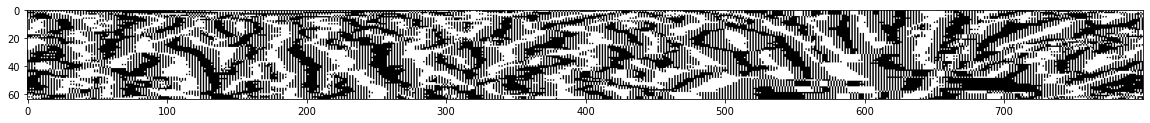

In [44]:
plt.figure(figsize=(20,20))
plt.imshow(template, cmap='gray')

In [45]:
def shiftbits_ham(template, noshifts):
    templatenew = np.zeros(template.shape)
    width = template.shape[1]
    s = 2 * np.abs(noshifts)
    p = width - s

    if noshifts == 0:
        templatenew = template

    elif noshifts < 0:
        x = np.arange(p)
        templatenew[:, x] = template[:, s + x]
        x = np.arange(p, width)
        templatenew[:, x] = template[:, x - p]

    else:
        x = np.arange(s, width)
        templatenew[:, x] = template[:, x - s]
        x = np.arange(s)
        templatenew[:, x] = template[:, p + x]

    return templatenew

In [46]:
def HammingDistance(template1, mask1, template2, mask2):
    hd = np.nan

    # Shifting template left and right, use the lowest Hamming distance
    for shifts in range(-8, 9):
        template1s = shiftbits_ham(template1, shifts)
        mask1s = shiftbits_ham(mask1, shifts)

        mask = np.logical_and(mask1s, mask2)
        nummaskbits = np.sum(mask == 1)
        totalbits = template1s.size - nummaskbits

        C = np.logical_xor(template1s, template2)
        C = np.logical_and(C, np.logical_not(mask))
        bitsdiff = np.sum(C == 1)

        if totalbits == 0:
            hd = np.nan
        else:
            hd1 = bitsdiff / totalbits
            if hd1 < hd or np.isnan(hd):
                hd = hd1

    return hd